# **Age Detection Model**

The age detection algorithm was developed using convulational neural networks (CNN). This is a class of deep learning models that are able to learn hierarchical representations from visual data. The algorithm does this my learning intricate patterns from these facial images, allowing it to predict the age of individuals  with a high level of accuracy.

The algorithm begins by loading and preprocessing a dataset of facial images. The data is then organized into a structured format, using Pandas for a streamlined analysis. The core of the age detection algorithm is uses CNN which is designed with convulational layers, batch normalization and max-pooling to extract relevent features from the facial images. In addition to this, fully connected layers are incorporated to make predictions for the age. The results are then evaluated to assess the model's learning progress over epochs. The methods used are explained in greater detail below.

First we start by importing the necessary libraries , including the Tensorflow and Keras Modules. Tensorflow is the backend for Keras that facilitates the design and training of deep learning models. Keras provides utilities for image data preprocessing including `keras.models` and `keras.layers`to enable high-level neural networks.

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
from keras.callbacks import ModelCheckpoint  # Import ModelCheckpoint

warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model, load_model  # Import load_model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
from keras.layers import BatchNormalization

The objective of this next step is to organize image paths along with associated age and gender labels for subsequent analysis and model training. The code utilizes a loop to iterate through each file in the specified directory, facilitated by `os.listdir(BASE_DIR)`, splitting the filenames with underscores into the following naming convention "age_gender". This is crucial for preparing a labeled dataset for easier usage.

In [ ]:
BASE_DIR = '/content/training200_2_rotations_only'

# labels - age, gender, ethnicity
image_paths = []
age_labels = []
gender_labels = []
race_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    race = int(temp[2])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)
    race_labels.append(race)

A Pandas Dataframe `df` is created to structure and organize the extracted information from the dataset. This will serve as a tabular stucture with 3 columns that aligns image paths with their corresponding labels in a coherent way.

In [ ]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'], df['race'] = image_paths, age_labels, gender_labels, race_labels
df.head()

# map labels for gender
gender_dict = {0:'Male', 1:'Female'}
# map labels for race
race_dict = {0: 'White', 1: 'Black', 2: 'Asian', 3: 'Indian', 4: 'Others'}

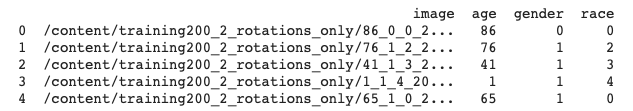

The code uses the Pillow library to open an image file specified in the path. The resulting image is then displayed using `Matplotlib` with the axis turned off to focus on the image content. This is a quick visual insepction of the images to ensure the data loading and preprocessing has been done correctly.

In [ ]:
# Display grid of images with age labels
plt.figure(figsize=(20, 20))
files = df.iloc[0:25]

for index, row in files.iterrows():
    img = load_img(row['image'])
    img = np.array(img)
    plt.subplot(5, 5, index % 25 + 1)
    plt.imshow(img)
    plt.title(f"Age: {row['age']}")
    plt.axis('off')

plt.tight_layout()  #to prevent overlap
plt.show()

plt.show()


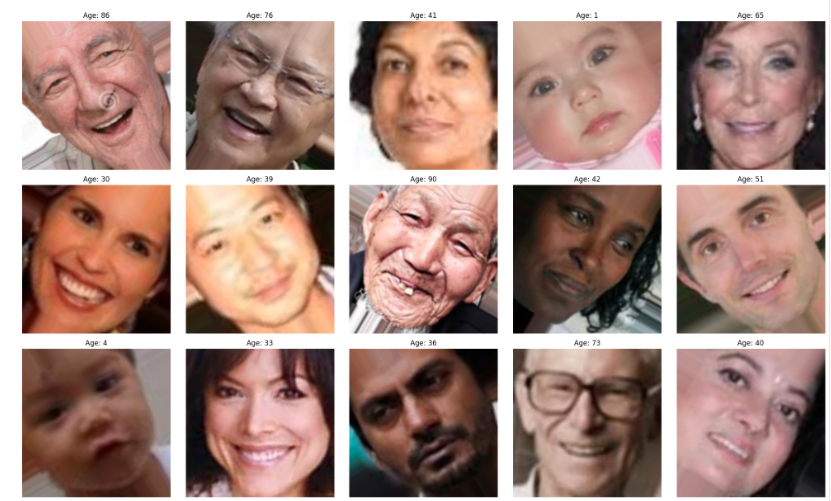

`distplot()` is Seaborn visualization functions applied to the age column. This will create a distribution of the age column, providing a visual representation of the distribution of ages within the dataset. This helps with understanding the concentration of the different groups. We have also counted the occurance of each unique value in the specified column and represented them as bars.

In [ ]:
# Plot age distribution
plt.figure(figsize=(10, 5))
sns.distplot(df['age'])
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Density')
plt.tight_layout()  #to prevent overlap
plt.show()

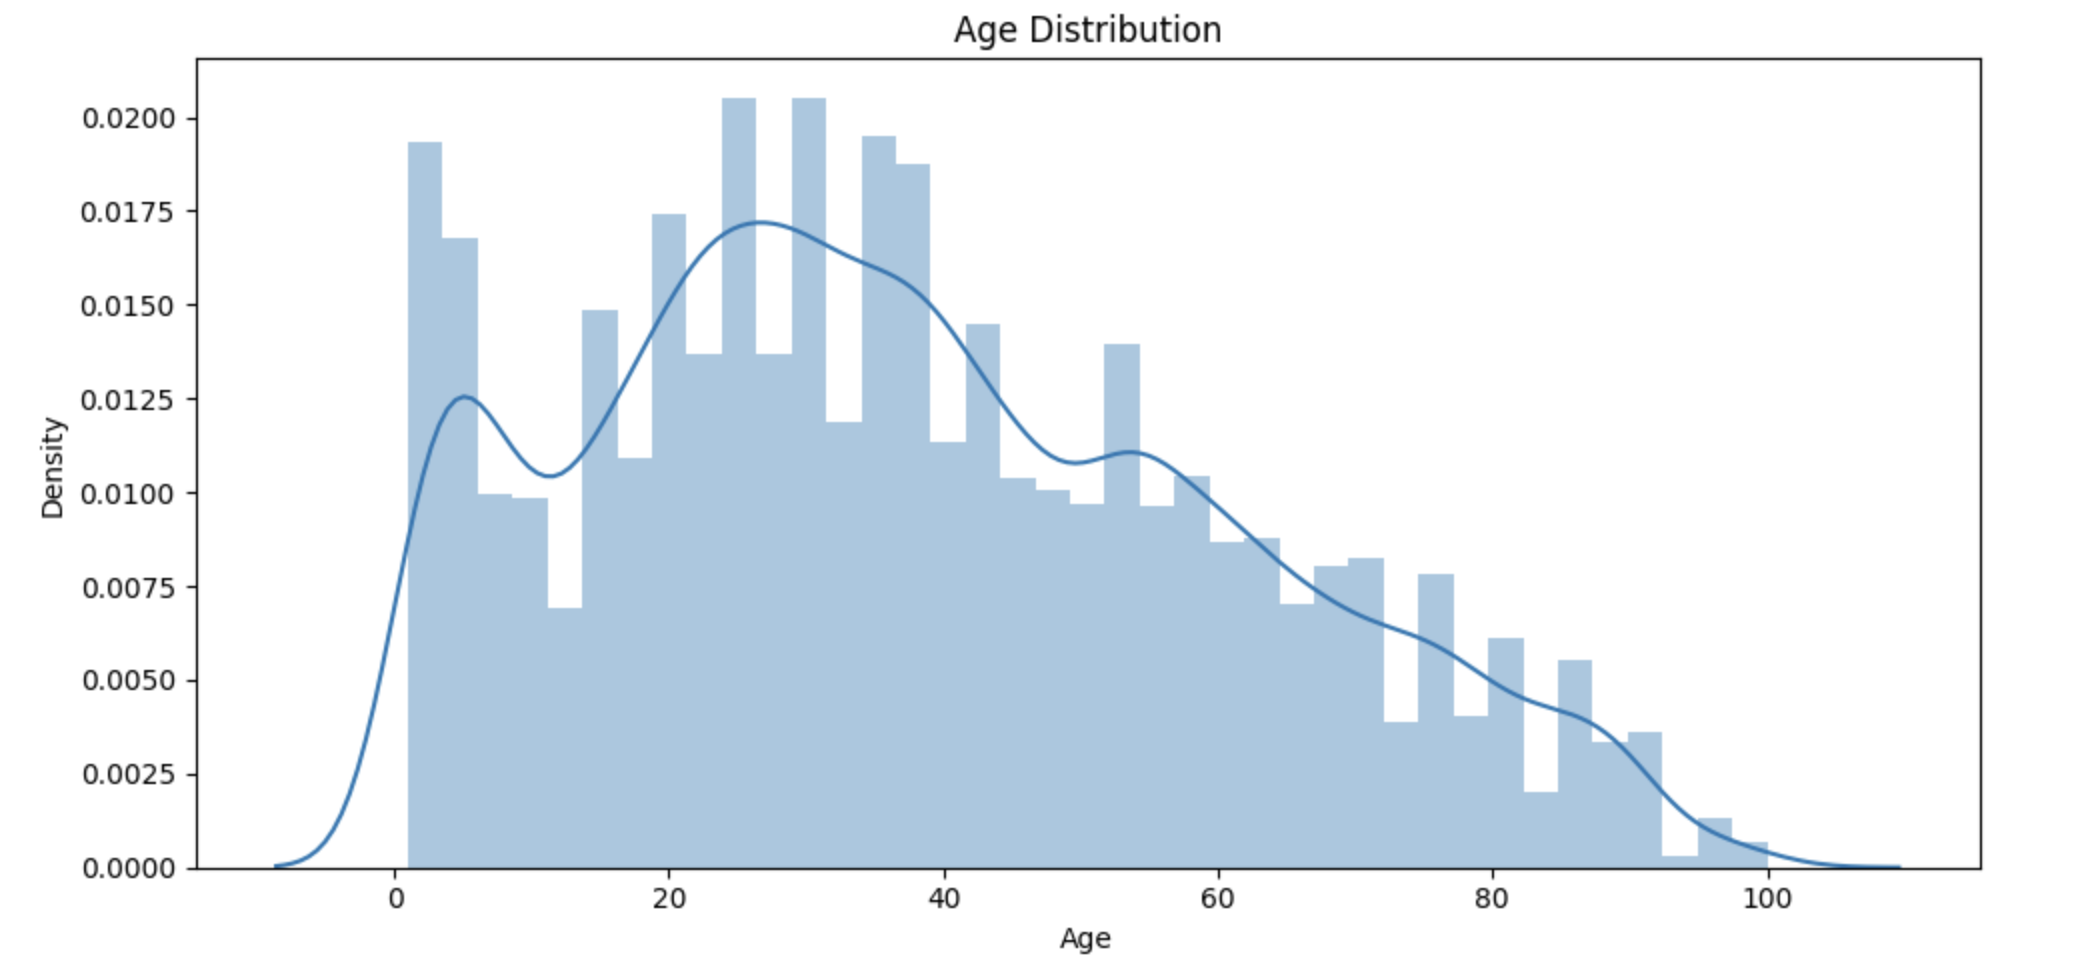




We define a function `extract_features` that takes the images and converts each image into a NumPy array. The resulting array represents the extracted features and is then reshaped to match the expected input for a CNN.

In [ ]:
# Extract features
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

Here we use the function created above to extract features from the images which are stored in the `X` array. the values stored in the array are pixel intensities and theses are normalised by diciding each value by 255. The gender and age columns are converted to NumPy arrays and assigned as needed. `input_shape` is a tuple that defines the expected shape of the input image. `Input()` is a Keras function that defines the input layer for a neural network model.

In [ ]:
X = extract_features(df['image'])
X = X/255.0

y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

input_shape = (128, 128, 1)

inputs = Input((input_shape))

Here we define a stack of convolutional layers with increasing complexity and feature extraction capabilities. Batch normalization is applied to stabilize training, and max pooling is used for spatial downsampling. The resulting feature maps from these layers are flattened and connected to fully connected layers for further processing and final predictions. In general the sequence of `conv2D`, `BatchNormalization` and `MaxPooling2D` does the following:


*   The `Conv2d Layer` is responsible for applying convolutional operations to the input data using filters and kernels over the input. It extracts features by performing element wise multiplications and summations. The number of filters in the Conv2D layer determines the depth of the feature maps it generates and increasing the number of filters allows the layer to capture more diverse and complex patterns.
*  `Batch Normalization` is used to normalize the inputs  of a layer, normalizing the activations of each neuron across a mini-batch of data. This helps in stabilizing and accelerating the training process. BatchNorm reduces the covariate shift by normalizing the inputs to have zero mean and unit variance. It also helps in addressing issues related to vanishing/exploding gradients during training.

*  `MaxPooling2D` is a down-sampling operation that reduces the spatial dimensions of the input feature maps by selecting the maximum value from a local region (a 2x2 window in our case).
Max pooling helps in reducing the computational complexity and controlling overfitting by retaining the most important information from the feature maps. It also provides a degree of translational invariance.



In [ ]:
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
conv_1 = BatchNormalization()(conv_1)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
conv_2 = BatchNormalization()(conv_2)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
conv_3 = BatchNormalization()(conv_3)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
conv_4 = BatchNormalization()(conv_4)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)
conv_5 = Conv2D(512, kernel_size=(3, 3), activation='relu') (maxp_4)
conv_5 = BatchNormalization()(conv_5)
maxp_5 = MaxPooling2D(pool_size=(2, 2)) (conv_5)

The resulting feature maps from these layers are flattened and connected to fully connected layers. Flatten is used to reshape the output from the convolutional layers into a one-dimensional array. The subsequent fully connected layers include a dense layer with 256 neurons, a dropout layer for regularization, and the final output layer for age prediction with a single neuron and ReLU activation.

In [ ]:
flatten = Flatten() (maxp_5)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)

# Output layer for age prediction
output_age = Dense(1, activation='relu', name='age_out')(dropout_1)

Now we establish the architecture of the neural network model. The model is configured to minimize the Mean Absolute Error during training using the Adam optimizer to minimize the absolute difference between predicted and actual values.

In [ ]:
# Model definition
model = Model(inputs=[inputs], outputs=[output_age])

model.compile(loss='mae', optimizer='adam', metrics=['mae'])

Finaly we complete the training process of the model for 30 epochs and the training history is stored.

In [ ]:
# Train model
history = model.fit(x=X, y=y_age, batch_size=32, epochs=30, validation_split=0.2)

# Save the model
model.save("model_v10.h5")

We have also created a graphical representation of the model architecture which is below

In [ ]:
# # plot the model
from keras.utils import plot_model
plot_model(model)

# Plot training history
def plot_training_history(history):
    # Plot training loss
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Graph')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

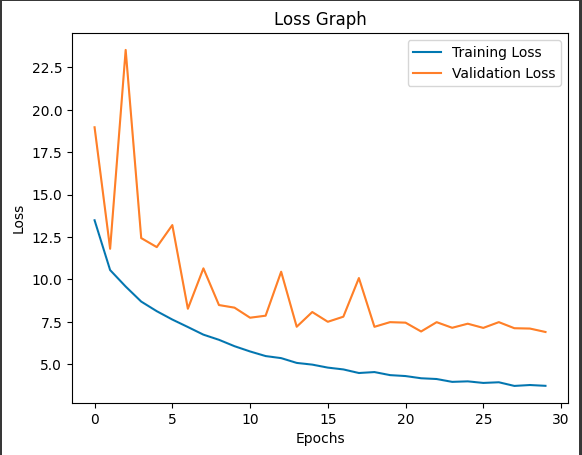